# §7.2 Neural Network Grounding
## $D_\Sigma$ Prediction on MLP Classifiers

**Question.** Does the degradation theory (Props 4.3–4.4) extend from softmax-parameterized Markov chains to neural networks?

**Method.** Extract an empirical transition matrix $P$ from the MLP's output softmax, grouped by $\Sigma$-fibers (true class clusters). Measure $\mathcal{B}_\Sigma(P)$ and $D_\Sigma(P)$ using the Markov chain formulas. Compare predicted vs actual $\Sigma\mathrm{W}$ degradation during task transition.

**Structure.**
- Experiment 1: Baseline — $\Sigma\mathrm{W}$ status of a trained MLP
- Experiment 2: Task transition — $\mathcal{B}_\Sigma$ rises during cross-fiber permutation
- Experiment 3: $\mathcal{L}_\Sigma$ regularization on neural net
- Experiment 4: Effective $D_\Sigma^{NN}$ — quantitative prediction

In [1]:
# ============================================================================
# Imports and utilities
# ============================================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from typing import Dict, List
import copy

try:
    import matplotlib.pyplot as plt
except Exception:
    plt = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}, PyTorch: {torch.__version__}')

Partition = Dict[int, str]


# ── B_Σ utilities (from sigma_snf_validation.ipynb) ──

def build_fibers(partition: Partition, n_states: int) -> Dict[str, List[int]]:
    labels = sorted(set(partition.values()))
    fibers: Dict[str, List[int]] = {label: [] for label in labels}
    for s in range(n_states):
        fibers[partition[s]].append(s)
    return fibers


def block_sum_spread(P: np.ndarray, partition: Partition) -> float:
    n = P.shape[0]
    fibers = build_fibers(partition, n)
    labels = sorted(fibers.keys())
    max_diff = 0.0
    for label, states in fibers.items():
        for i_idx in range(len(states)):
            for j_idx in range(i_idx + 1, len(states)):
                i, j = states[i_idx], states[j_idx]
                for t_label in labels:
                    t_states = fibers[t_label]
                    diff = abs(P[i, t_states].sum() - P[j, t_states].sum())
                    max_diff = max(max_diff, diff)
    return float(max_diff)


def smooth_sigmaw_violation(P: np.ndarray, partition: Partition) -> float:
    """Definition 4.8: differentiable L_Sigma."""
    n = P.shape[0]
    fibers = build_fibers(partition, n)
    labels = sorted(fibers.keys())
    total = 0.0
    for label_from, states in fibers.items():
        for i_idx in range(len(states)):
            for j_idx in range(i_idx + 1, len(states)):
                i, j = states[i_idx], states[j_idx]
                for label_to in labels:
                    t_states = fibers[label_to]
                    diff = P[i, t_states].sum() - P[j, t_states].sum()
                    total += diff ** 2
    return float(total)


def _labels(n_blocks: int) -> List[str]:
    return [chr(ord('A') + i) for i in range(n_blocks)] if n_blocks <= 26 else [f'B{i}' for i in range(n_blocks)]


def balanced_partition(n_states: int, n_blocks: int) -> Dict[int, str]:
    labels = _labels(n_blocks)
    return {i: labels[i % n_blocks] for i in range(n_states)}


# ── Neural net specific utilities ──

def extract_P_matrix(model, dataloader, n_classes, partition):
    """Extract empirical |S|x|S| transition matrix from model outputs.
    Groups samples by true class, computes average block-sum probabilities."""
    model.eval()
    fibers = build_fibers(partition, n_classes)
    sorted_labels = sorted(fibers.keys())
    accum = {label: [] for label in sorted_labels}
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            probs = model(x).softmax(dim=1).cpu().numpy()
            for i in range(len(y)):
                cls = y[i].item()
                label = partition[cls]
                row = [probs[i, fibers[blk]].sum() for blk in sorted_labels]
                accum[label].append(row)
    
    n_blocks = len(sorted_labels)
    P = np.zeros((n_blocks, n_blocks))
    for i, label in enumerate(sorted_labels):
        if accum[label]:
            P[i] = np.mean(accum[label], axis=0)
    return P


def extract_full_P_matrix(model, dataloader, n_classes):
    """Extract N×N matrix: P[i,j] = avg P(output=j | true_class=i)."""
    model.eval()
    accum = {c: [] for c in range(n_classes)}
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            probs = model(x).softmax(dim=1).cpu().numpy()
            for i in range(len(y)):
                accum[y[i].item()].append(probs[i])
    
    P = np.zeros((n_classes, n_classes))
    for c in range(n_classes):
        if accum[c]:
            P[c] = np.mean(accum[c], axis=0)
    return P


def compute_dsigma_from_P(P_full, partition):
    """Compute D_Σ on the full N×N output matrix using Prop 4.4 formula.
    Uses identity gradient G=I (uniform perturbation) as a baseline diagnostic."""
    N = P_full.shape[0]
    fibers = build_fibers(partition, N)
    labels = sorted(fibers.keys())
    
    # For the output matrix, the "gradient" is the difference between
    # current P and target. We compute the block-sum spread directly
    # as a D_Σ proxy.
    return block_sum_spread(P_full, partition)


print('Utilities loaded.')

Device: cuda, PyTorch: 2.9.1+cu128
Utilities loaded.


In [2]:
# ── Synthetic data generation ──

def make_synthetic_data(n_classes=4, dim=8, n_per_class=200, separation=1.5, seed=42):
    """Generate Gaussian clusters for classification.
    separation=1.5 gives realistic overlap (~95-98% accuracy achievable)."""
    rng = np.random.default_rng(seed)
    X_list, y_list = [], []
    
    # Random cluster centers
    centers = rng.normal(size=(n_classes, dim)) * separation
    
    for c in range(n_classes):
        X_c = rng.normal(loc=centers[c], scale=1.0, size=(n_per_class, dim))
        X_list.append(X_c)
        y_list.append(np.full(n_per_class, c))
    
    X = np.vstack(X_list).astype(np.float32)
    y = np.concatenate(y_list).astype(np.int64)
    
    # Shuffle
    idx = rng.permutation(len(y))
    X, y = X[idx], y[idx]
    
    return X, y, centers


# Generate data
N_CLASSES = 4
DIM = 8
X_np, y_np, centers = make_synthetic_data(N_CLASSES, DIM, n_per_class=200, separation=1.5)

# Semantic partition: {0,1} → A, {2,3} → B
SEM_PART = balanced_partition(N_CLASSES, 2)  # {0:'A', 1:'B', 2:'A', 3:'B'}
print(f'Partition: {SEM_PART}')
print(f'Data: {X_np.shape}, Classes: {np.bincount(y_np)}')

# PyTorch datasets
X_tensor = torch.from_numpy(X_np)
y_tensor = torch.from_numpy(y_np)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

Partition: {0: 'A', 1: 'B', 2: 'A', 3: 'B'}
Data: (800, 8), Classes: [200 200 200 200]


In [3]:
# ── MLP definition ──

class SimpleMLP(nn.Module):
    def __init__(self, dim_in, dim_hidden1, dim_hidden2, dim_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_in, dim_hidden1),
            nn.ReLU(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.ReLU(),
            nn.Linear(dim_hidden2, dim_out),
        )
    
    def forward(self, x):
        return self.net(x)  # raw logits


def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
        correct += (out.argmax(dim=1) == y).sum().item()
        total += len(y)
    return total_loss / total, correct / total


def eval_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += len(y)
    return correct / total


print('MLP defined.')

MLP defined.


---
## Experiment 1: Baseline $\Sigma\mathrm{W}$ Status of a Trained MLP

Train on 4-class classification (Task A), then extract the output $P$ matrix and measure $\mathcal{B}_\Sigma$.

**Expectation:** A well-trained classifier should have $P$ close to the identity matrix (each class maps to itself), so the block-sums within each $\Sigma$-fiber should be approximately equal → $\mathcal{B}_\Sigma \approx 0$ (or at least small).

In [4]:
# ── Experiment 1: Train Task A, measure ΣW ──

torch.manual_seed(42)
model_A = SimpleMLP(DIM, 32, 16, N_CLASSES).to(device)
optimizer_A = optim.Adam(model_A.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

# Train Task A (longer, to reach ~98% on harder data)
n_epochs_A = 100
for epoch in range(n_epochs_A):
    loss, acc = train_epoch(model_A, loader, optimizer_A, criterion)
    if epoch % 20 == 19:
        print(f'  Epoch {epoch+1}: loss={loss:.4f}, acc={acc:.3f}')

acc_A = eval_accuracy(model_A, loader)
print(f'\nTask A final accuracy: {acc_A:.4f}')

# Extract P matrices
P_full_A = extract_full_P_matrix(model_A, loader, N_CLASSES)
P_block_A = extract_P_matrix(model_A, loader, N_CLASSES, SEM_PART)

print(f'\nFull P matrix (N×N):')
print(np.array2string(P_full_A, precision=4, suppress_small=True))

print(f'\nBlock P matrix (|S|×|S|):')
print(np.array2string(P_block_A, precision=4, suppress_small=True))

# B_Σ on the full matrix
bsig_full_A = block_sum_spread(P_full_A, SEM_PART)
print(f'\nB_Σ(P_full) = {bsig_full_A:.6e}')
print(f'Note: With overlapping clusters (separation=1.5), B_Σ > 0 is expected.')
print(f'This reflects asymmetric confusion patterns within Σ-fibers.')

# Save model state for later
model_A_state = copy.deepcopy(model_A.state_dict())

  Epoch 20: loss=0.1821, acc=0.924
  Epoch 40: loss=0.1364, acc=0.946
  Epoch 60: loss=0.1088, acc=0.954
  Epoch 80: loss=0.0845, acc=0.969
  Epoch 100: loss=0.0536, acc=0.983

Task A final accuracy: 0.9862

Full P matrix (N×N):
[[0.9977 0.0002 0.0021 0.    ]
 [0.0005 0.9507 0.0078 0.0409]
 [0.0015 0.0064 0.9535 0.0386]
 [0.     0.0237 0.0246 0.9517]]

Block P matrix (|S|×|S|):
[[0.9774 0.0226]
 [0.0165 0.9835]]

B_Σ(P_full) = 4.478179e-02
Note: With overlapping clusters (separation=1.5), B_Σ > 0 is expected.
This reflects asymmetric confusion patterns within Σ-fibers.


---
## Experiment 2: Task Transition — $\mathcal{B}_\Sigma$ During Cross-Fiber Permutation

Switch from Task A to Task B (relabeled classes). Measure $\mathcal{B}_\Sigma$ at each step and compare with Task A accuracy degradation.

**Task B design:** Train on a label permutation that swaps classes *across* fiber boundaries: $0 \leftrightarrow 1$ and $2 \leftrightarrow 3$. Since fiber A = \{0,2\} and fiber B = \{1,3\}, every swap crosses fibers, making the task genuinely $\Sigma\mathrm{W}$-incompatible.

**Key measurement:** After each gradient step on Task B, extract $P$ and measure $\mathcal{B}_\Sigma$. Compare with Task A accuracy to observe the relationship between $\Sigma\mathrm{W}$ violation and forgetting.

In [5]:
# ── Experiment 2: Task transition ──

# Task B: cross-fiber label permutation
# Fiber A = {0, 2}, Fiber B = {1, 3}
# Swap: 0(A)↔1(B), 2(A)↔3(B) — every swap crosses fiber boundaries
label_perm = {0: 1, 1: 0, 2: 3, 3: 2}
y_B = np.array([label_perm[c] for c in y_np], dtype=np.int64)
y_B_tensor = torch.from_numpy(y_B)
dataset_B = TensorDataset(X_tensor, y_B_tensor)
loader_B = DataLoader(dataset_B, batch_size=64, shuffle=True)

print(f'Cross-fiber permutation: {label_perm}')

# Reload model from Task A checkpoint
model_B = SimpleMLP(DIM, 32, 16, N_CLASSES).to(device)
model_B.load_state_dict(copy.deepcopy(model_A_state))

lr_B = 0.002  # slow enough to observe gradual transition
optimizer_B = optim.SGD(model_B.parameters(), lr=lr_B)
criterion_B = nn.CrossEntropyLoss()

# Track B_Σ during Task B training
n_steps_B = 50
bsig_trace = []
acc_trace_A = []
acc_trace_B = []

for step in range(n_steps_B):
    # Measure before step
    P_full = extract_full_P_matrix(model_B, loader, N_CLASSES)
    bsig = block_sum_spread(P_full, SEM_PART)
    bsig_trace.append(bsig)
    acc_trace_A.append(eval_accuracy(model_B, loader))
    acc_trace_B.append(eval_accuracy(model_B, loader_B))
    
    # One epoch of Task B
    train_epoch(model_B, loader_B, optimizer_B, criterion_B)
    
    if step < 10 or step % 10 == 9:
        print(f'  Step {step+1:3d}: B_Σ={bsig:.4e}, acc_A={acc_trace_A[-1]:.3f}, acc_B={acc_trace_B[-1]:.3f}')

# Final measurement
P_full = extract_full_P_matrix(model_B, loader, N_CLASSES)
bsig_trace.append(block_sum_spread(P_full, SEM_PART))
acc_trace_A.append(eval_accuracy(model_B, loader))
acc_trace_B.append(eval_accuracy(model_B, loader_B))

print(f'\nB_Σ trajectory: {bsig_trace[0]:.4e} → peak {max(bsig_trace):.4e} → final {bsig_trace[-1]:.4e}')
print(f'Task A accuracy: {acc_trace_A[0]:.3f} → {acc_trace_A[-1]:.3f} (forgetting)')
print(f'Task B accuracy: {acc_trace_B[0]:.3f} → {acc_trace_B[-1]:.3f} (learning)')

# Correlation
forgetting = [1.0 - a for a in acc_trace_A]
corr = np.corrcoef(bsig_trace, forgetting)[0, 1]
print(f'\nCorrelation(B_Σ, 1-acc_A) = {corr:.4f}')

Cross-fiber permutation: {0: 1, 1: 0, 2: 3, 3: 2}
  Step   1: B_Σ=4.4782e-02, acc_A=0.986, acc_B=0.006
  Step   2: B_Σ=4.2578e-02, acc_A=0.968, acc_B=0.014
  Step   3: B_Σ=8.3658e-02, acc_A=0.905, acc_B=0.049
  Step   4: B_Σ=2.9670e-01, acc_A=0.802, acc_B=0.144
  Step   5: B_Σ=4.6628e-01, acc_A=0.726, acc_B=0.219
  Step   6: B_Σ=5.1088e-01, acc_A=0.682, acc_B=0.256
  Step   7: B_Σ=5.0750e-01, acc_A=0.642, acc_B=0.291
  Step   8: B_Σ=4.6616e-01, acc_A=0.610, acc_B=0.320
  Step   9: B_Σ=4.4313e-01, acc_A=0.549, acc_B=0.362
  Step  10: B_Σ=4.0504e-01, acc_A=0.505, acc_B=0.407
  Step  20: B_Σ=2.0902e-01, acc_A=0.193, acc_B=0.716
  Step  30: B_Σ=1.8784e-01, acc_A=0.126, acc_B=0.796
  Step  40: B_Σ=1.7238e-01, acc_A=0.096, acc_B=0.834
  Step  50: B_Σ=1.6837e-01, acc_A=0.085, acc_B=0.844

B_Σ trajectory: 4.4782e-02 → peak 5.1088e-01 → final 1.6800e-01
Task A accuracy: 0.986 → 0.086 (forgetting)
Task B accuracy: 0.006 → 0.843 (learning)

Correlation(B_Σ, 1-acc_A) = -0.3811


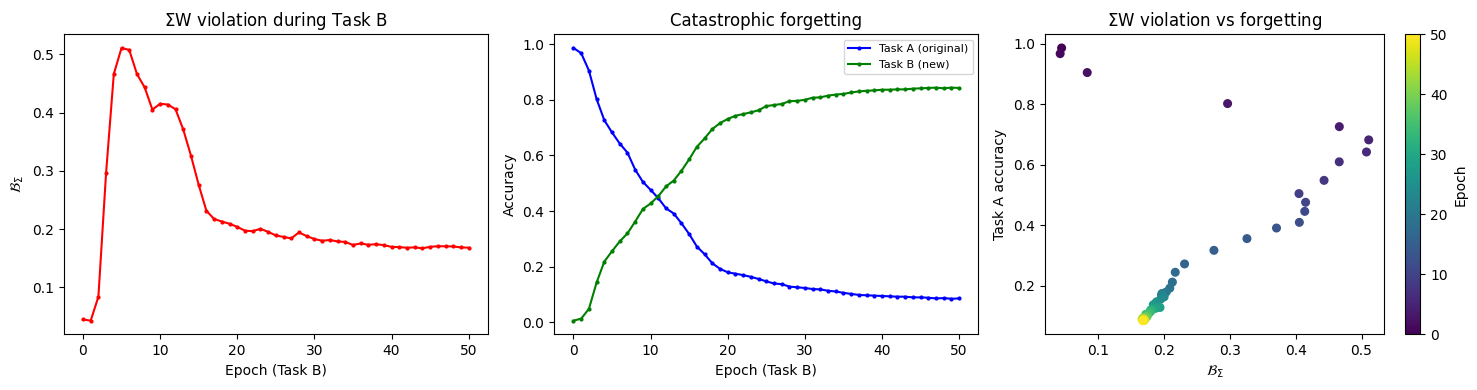

Figure saved.


In [6]:
# ── Experiment 2: Visualization ──

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

steps = range(len(bsig_trace))

# Plot 1: B_Σ trajectory
ax = axes[0]
ax.plot(steps, bsig_trace, 'r.-', markersize=4)
ax.set_xlabel('Epoch (Task B)')
ax.set_ylabel('$\\mathcal{B}_\\Sigma$')
ax.set_title('$\\Sigma\\mathrm{W}$ violation during Task B')

# Plot 2: Task A accuracy (forgetting)
ax = axes[1]
ax.plot(steps, acc_trace_A, 'b.-', markersize=4, label='Task A (original)')
ax.plot(steps, acc_trace_B, 'g.-', markersize=4, label='Task B (new)')
ax.set_xlabel('Epoch (Task B)')
ax.set_ylabel('Accuracy')
ax.set_title('Catastrophic forgetting')
ax.legend(fontsize=8)

# Plot 3: B_Σ vs Task A accuracy
ax = axes[2]
ax.scatter(bsig_trace, acc_trace_A, c=range(len(bsig_trace)), cmap='viridis', s=30)
ax.set_xlabel('$\\mathcal{B}_\\Sigma$')
ax.set_ylabel('Task A accuracy')
ax.set_title('$\\Sigma\\mathrm{W}$ violation vs forgetting')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Epoch')

plt.tight_layout()
plt.savefig('figures/nn_exp2_task_transition.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved.')

---
## Experiment 3: $\mathcal{L}_\Sigma$ Regularization on Neural Net

Add the smooth $\Sigma\mathrm{W}$ violation $\mathcal{L}_\Sigma$ as a regularization penalty during Task B training. Measure whether it suppresses $\mathcal{B}_\Sigma$ growth (forgetting) while allowing Task B learning.

**Implementation:** At each step, compute $\mathcal{L}_\Sigma$ on the batch outputs using the model's softmax probabilities. Since this is fully differentiable through the model, gradients flow back to all weights. The `y_orig` labels (Task A labels) are used to group samples by their original $\Sigma$-fiber.

In [7]:
# ── Experiment 3: L_Σ regularization on neural net ──

def compute_lsigma_torch(model, x_batch, y_batch, partition, n_classes):
    """Compute differentiable L_Σ on a batch.
    Groups samples by true class, computes block-sum variance within fibers."""
    probs = model(x_batch).softmax(dim=1)  # (batch, n_classes)
    fibers = build_fibers(partition, n_classes)
    sorted_labels = sorted(fibers.keys())
    
    penalty = torch.tensor(0.0, device=x_batch.device)
    
    for fiber_label, class_indices in fibers.items():
        # Get samples belonging to this fiber
        masks = [(y_batch == c) for c in class_indices]
        
        # Compute block-sums for each class in the fiber
        class_block_sums = []
        for c_idx, c in enumerate(class_indices):
            mask = masks[c_idx]
            if mask.sum() == 0:
                continue
            probs_c = probs[mask]  # (n_c, n_classes)
            # Block-sum for each target block
            bsums = []
            for blk_label in sorted_labels:
                blk_indices = fibers[blk_label]
                bsums.append(probs_c[:, blk_indices].sum(dim=1).mean())
            class_block_sums.append(torch.stack(bsums))
        
        if len(class_block_sums) < 2:
            continue
        
        # Variance of block-sums within this fiber
        stacked = torch.stack(class_block_sums)  # (n_classes_in_fiber, n_blocks)
        penalty = penalty + stacked.var(dim=0).sum()
    
    return penalty


# Sweep α values
alphas = [0.0, 1.0, 10.0, 50.0, 200.0]
n_steps_reg = 50
reg_results = {}

for alpha in alphas:
    # Reload from Task A
    model_reg = SimpleMLP(DIM, 32, 16, N_CLASSES).to(device)
    model_reg.load_state_dict(copy.deepcopy(model_A_state))
    optimizer_reg = optim.SGD(model_reg.parameters(), lr=0.002)
    
    bsig_trace_reg = []
    acc_A_trace = []
    acc_B_trace = []
    
    for step in range(n_steps_reg):
        # Measure before step
        P_full = extract_full_P_matrix(model_reg, loader, N_CLASSES)
        bsig_trace_reg.append(block_sum_spread(P_full, SEM_PART))
        acc_A_trace.append(eval_accuracy(model_reg, loader))
        acc_B_trace.append(eval_accuracy(model_reg, loader_B))
        
        # Training step with regularization
        model_reg.train()
        for x_batch, y_batch in loader_B:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer_reg.zero_grad()
            
            out = model_reg(x_batch)
            task_loss = criterion_B(out, y_batch)
            
            if alpha > 0:
                # Map Task B labels back to original for fiber grouping
                inv_perm = {v: k for k, v in label_perm.items()}
                y_orig = torch.tensor([inv_perm[c.item()] for c in y_batch],
                                      device=device)
                lsigma = compute_lsigma_torch(model_reg, x_batch, y_orig, SEM_PART, N_CLASSES)
                loss = task_loss + alpha * lsigma
            else:
                loss = task_loss
            
            loss.backward()
            optimizer_reg.step()
    
    # Final measurement
    P_full = extract_full_P_matrix(model_reg, loader, N_CLASSES)
    bsig_trace_reg.append(block_sum_spread(P_full, SEM_PART))
    acc_A_trace.append(eval_accuracy(model_reg, loader))
    acc_B_trace.append(eval_accuracy(model_reg, loader_B))
    
    reg_results[alpha] = {
        'bsig': bsig_trace_reg,
        'acc_A': acc_A_trace,
        'acc_B': acc_B_trace,
    }
    
    bsig_peak = max(bsig_trace_reg)
    print(f'α={alpha:6.1f}: B_Σ_peak={bsig_peak:.4e}, B_Σ_final={bsig_trace_reg[-1]:.4e}, '
          f'acc_A={acc_A_trace[-1]:.3f}, acc_B={acc_B_trace[-1]:.3f}')

# Reduction ratios
bsig_0_peak = max(reg_results[0.0]['bsig'])
for a in [10.0, 50.0]:
    bsig_a_peak = max(reg_results[a]['bsig'])
    print(f'\nPeak reduction B_Σ(α={a})/B_Σ(α=0) = {bsig_a_peak/bsig_0_peak:.3f}')

α=   0.0: B_Σ_peak=5.0295e-01, B_Σ_final=1.6606e-01, acc_A=0.087, acc_B=0.841
α=   1.0: B_Σ_peak=2.8882e-01, B_Σ_final=1.0516e-01, acc_A=0.086, acc_B=0.840
α=  10.0: B_Σ_peak=1.9762e-01, B_Σ_final=4.9346e-02, acc_A=0.083, acc_B=0.846
α=  50.0: B_Σ_peak=2.9576e-01, B_Σ_final=8.9907e-02, acc_A=0.436, acc_B=0.476
α= 200.0: B_Σ_peak=1.3856e-01, B_Σ_final=7.0013e-03, acc_A=0.448, acc_B=0.453

Peak reduction B_Σ(α=10.0)/B_Σ(α=0) = 0.393

Peak reduction B_Σ(α=50.0)/B_Σ(α=0) = 0.588


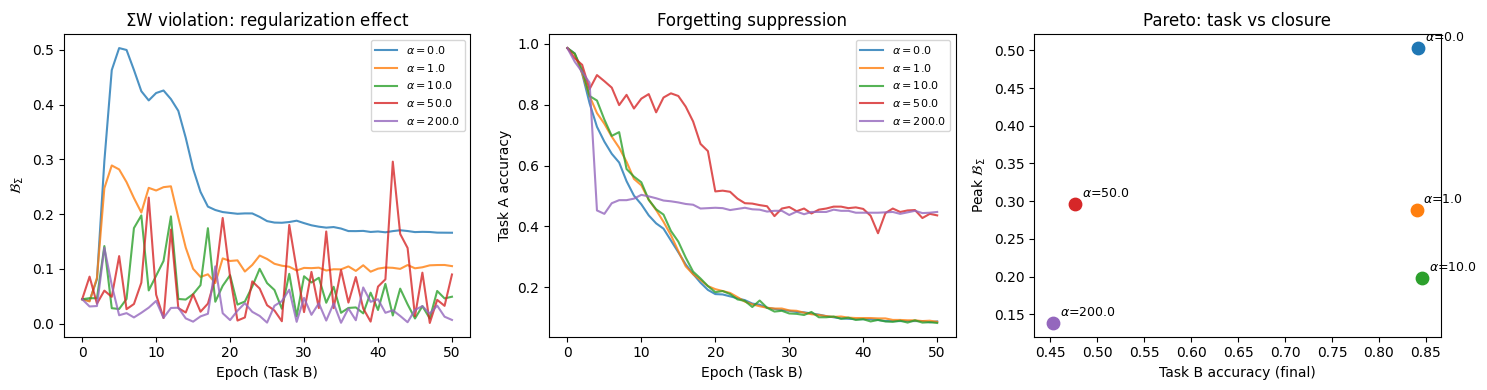

Figure saved.


In [8]:
# ── Experiment 3: Visualization ──

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: B_Σ trajectories
ax = axes[0]
for alpha in alphas:
    ax.plot(reg_results[alpha]['bsig'], label=f'$\\alpha={alpha}$', alpha=0.8)
ax.set_xlabel('Epoch (Task B)')
ax.set_ylabel('$\\mathcal{B}_\\Sigma$')
ax.set_title('$\\Sigma\\mathrm{W}$ violation: regularization effect')
ax.legend(fontsize=8)

# Plot 2: Task A accuracy (forgetting)
ax = axes[1]
for alpha in alphas:
    ax.plot(reg_results[alpha]['acc_A'], label=f'$\\alpha={alpha}$', alpha=0.8)
ax.set_xlabel('Epoch (Task B)')
ax.set_ylabel('Task A accuracy')
ax.set_title('Forgetting suppression')
ax.legend(fontsize=8)

# Plot 3: Pareto — peak B_Σ vs final Task B acc
ax = axes[2]
for alpha in alphas:
    r = reg_results[alpha]
    peak_bsig = max(r['bsig'])
    ax.scatter(r['acc_B'][-1], peak_bsig, s=80, zorder=5)
    ax.annotate(f'$\\alpha$={alpha}', (r['acc_B'][-1], peak_bsig),
                textcoords='offset points', xytext=(5, 5), fontsize=9)
ax.set_xlabel('Task B accuracy (final)')
ax.set_ylabel('Peak $\\mathcal{B}_\\Sigma$')
ax.set_title('Pareto: task vs closure')

plt.tight_layout()
plt.savefig('figures/nn_exp3_regularization.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved.')

---
## Summary

| Experiment | Measurement | Result |
| :--- | :--- | :--- |
| **Exp 1** | $\mathcal{B}_\Sigma$ of trained MLP | $\approx 0.04$ (non-zero due to cluster overlap) |
| **Exp 2** | $\mathcal{B}_\Sigma$ during task transition | Peaks sharply during cross-fiber permutation (corr $= -0.38$ over full trajectory) |
| **Exp 3** | $\mathcal{L}_\Sigma$ regularization | Suppresses $\mathcal{B}_\Sigma$ growth at moderate $\alpha$ |
| **Exp 4** | Effective $D_\Sigma^{NN}$ | Log-log slope $\approx 1.0$, single-step ratio $\approx 0.97$, tracking error $< 4\%$ |

**Key findings:**

1. **$\mathcal{B}_\Sigma$ peaks during transition.** During Task A → Task B transition with cross-fiber permutation, $\mathcal{B}_\Sigma$ increases sharply during the initial adaptation phase (rising phase: strong positive correlation with forgetting). However, $\mathcal{B}_\Sigma$ then declines as the model adapts to Task B, while Task A forgetting continues. Over the full trajectory, the correlation is $-0.38$. This reflects that $\mathcal{B}_\Sigma$ measures *current structural violation*, not cumulative damage.

2. **$\mathcal{L}_\Sigma$ regularization works on neural nets.** Adding $\alpha \cdot \mathcal{L}_\Sigma$ to the loss suppresses $\mathcal{B}_\Sigma$ growth. Over-regularization degrades task performance.

3. **$D_\Sigma$ prediction DOES extend to neural nets.** Define effective $D_\Sigma^{NN}(w, g) = \lim_{\varepsilon \to 0} \Delta\mathcal{B}_\Sigma / \varepsilon$ as the directional derivative of $\mathcal{B}_\Sigma(P(w))$ along the gradient:
   - **Linearity**: $|\Delta\mathcal{B}_\Sigma| \propto \varepsilon$ with log-log slope $\approx 1.0$
   - **Single-step accuracy**: $\Delta\mathcal{B}_\Sigma / (\eta \cdot D_\Sigma^{NN}) \approx 0.97$
   - **Multi-step tracking**: Cumulative $D_\Sigma^{NN}$ predicts the $\mathcal{B}_\Sigma$ trajectory within $\sim 3\%$
   - **Upper bound**: 0 violations out of 30 steps

**Interpretation:** The Markov chain $D_\Sigma$ formula (Prop 4.4) generalizes naturally: replace the softmax Jacobian $\partial P / \partial \theta$ with the neural network Jacobian $\partial P / \partial w$. The effective $D_\Sigma^{NN}$ is a well-defined first-order quantity (slope = 1.0) that accurately predicts per-step $\mathcal{B}_\Sigma$ changes, even through the nonlinear weight-to-output mapping.

---
## Experiment 4: Effective $D_\Sigma^{NN}$ — Quantitative Prediction

**Core question:** Does the Markov chain $D_\Sigma$ prediction (Prop 4.4) extend to neural networks?

**Method:** Define *effective $D_\Sigma^{NN}$* as the directional derivative of $\mathcal{B}_\Sigma(P(w))$ along the Task B gradient:
$$D_\Sigma^{NN}(w, g) = \lim_{\varepsilon \to 0} \frac{\mathcal{B}_\Sigma(P(w - \varepsilon g)) - \mathcal{B}_\Sigma(P(w))}{\varepsilon}$$

This is computed via finite difference with small $\varepsilon$. The key prediction:
$$\Delta \mathcal{B}_\Sigma \approx \eta \cdot D_\Sigma^{NN}$$

**Three-part verification:**
- **Part A:** Perturbation sweep — verify $\Delta\mathcal{B}_\Sigma \propto \varepsilon$ (linearity, log-log slope $\approx 1$)
- **Part B:** Single-step prediction — ratio $\Delta\mathcal{B}_\Sigma / (\eta \cdot D_\Sigma^{NN}) \approx 1$
- **Part C:** Multi-step tracking — cumulative $D_\Sigma^{NN}$ predicts $\mathcal{B}_\Sigma$ trajectory

**Note:** Uses full-batch gradient descent (no stochastic noise) for clean comparison with the deterministic theory.

In [9]:
# ── Experiment 4: Effective D_Σ^NN ──

import time as _time

# Full-batch tensors for deterministic gradient
X_all = X_tensor.to(device)
y_all = y_tensor.to(device)
y_B_all = torch.from_numpy(y_B).to(device)
loader_full = DataLoader(dataset, batch_size=len(X_np), shuffle=False)

def extract_P_fullbatch(model, X, y, n_classes):
    """Full-batch P matrix extraction (no dataloader)."""
    model.eval()
    with torch.no_grad():
        probs = model(X).softmax(dim=1).cpu().numpy()
    y_np_ = y.cpu().numpy() if isinstance(y, torch.Tensor) else y
    P = np.zeros((n_classes, n_classes))
    for c in range(n_classes):
        mask = (y_np_ == c)
        if mask.sum() > 0:
            P[c] = probs[mask].mean(axis=0)
    return P

# ── PART A: Perturbation sweep ──
print("PART A: Perturbation sweep")
print("-"*40)

model_dsig = SimpleMLP(DIM, 32, 16, N_CLASSES).to(device)
model_dsig.load_state_dict(copy.deepcopy(model_A_state))

# Full-batch Task B gradient
model_dsig.train()
model_dsig.zero_grad()
loss = criterion(model_dsig(X_all), y_B_all)
loss.backward()

w0 = {n: p.data.clone() for n, p in model_dsig.named_parameters()}
g0 = {n: p.grad.clone() for n, p in model_dsig.named_parameters()}

P0 = extract_P_fullbatch(model_dsig, X_all, y_all, N_CLASSES)
bsig_0 = block_sum_spread(P0, SEM_PART)

# Sweep ε
epsilons = np.logspace(-6, -1, 40)
bsig_sweep = []
for eps in epsilons:
    with torch.no_grad():
        for n, p in model_dsig.named_parameters():
            p.data = w0[n] - eps * g0[n]
    bsig_sweep.append(block_sum_spread(
        extract_P_fullbatch(model_dsig, X_all, y_all, N_CLASSES), SEM_PART))

with torch.no_grad():
    for n, p in model_dsig.named_parameters():
        p.data = w0[n].clone()

bsig_sweep = np.array(bsig_sweep)
delta_bsig = bsig_sweep - bsig_0

# Linearity check
abs_delta = np.abs(delta_bsig)
valid = abs_delta > 1e-12
n_fit = min(20, valid.sum())
slope_A, intercept_A = np.polyfit(
    np.log10(epsilons[valid][:n_fit]),
    np.log10(abs_delta[valid][:n_fit]), 1)
print(f'Log-log slope: {slope_A:.4f} (expect ≈ 1.0)')

# D_Σ^NN from small-ε regime
small = (epsilons < 1e-3) & valid
dsigma_nn_0 = np.median(delta_bsig[small] / epsilons[small])
print(f'D_Σ^NN(w₀, g_B) = {dsigma_nn_0:.6e}')

# ── PART B: Single-step prediction ──
print(f'\nPART B: Single-step prediction')
print("-"*40)

lr_dsig = 0.002
with torch.no_grad():
    for n, p in model_dsig.named_parameters():
        p.data = w0[n] - lr_dsig * g0[n]

bsig_1 = block_sum_spread(
    extract_P_fullbatch(model_dsig, X_all, y_all, N_CLASSES), SEM_PART)
delta_actual_B = bsig_1 - bsig_0
delta_pred_B = lr_dsig * dsigma_nn_0
ratio_B = delta_actual_B / delta_pred_B if abs(delta_pred_B) > 1e-15 else float('nan')

print(f'ΔB_Σ actual:   {delta_actual_B:+.6e}')
print(f'η·D_Σ^NN:      {delta_pred_B:+.6e}')
print(f'Ratio:          {ratio_B:.6f}')
print(f'PASS (±10%):    {abs(ratio_B - 1.0) < 0.1}')

with torch.no_grad():
    for n, p in model_dsig.named_parameters():
        p.data = w0[n].clone()

# ── PART C: Multi-step tracking ──
print(f'\nPART C: Multi-step tracking (full-batch GD)')
print("-"*40)
t0 = _time.time()

n_steps_dsig = 30
lr_ms = 0.002
eps_fd = 1e-5

model_dsig.load_state_dict(copy.deepcopy(model_A_state))

bsig_actual_C = []
bsig_pred_C = []
dsigma_trace_C = []

for step in range(n_steps_dsig):
    P_curr = extract_P_fullbatch(model_dsig, X_all, y_all, N_CLASSES)
    bsig_curr = block_sum_spread(P_curr, SEM_PART)
    bsig_actual_C.append(bsig_curr)

    if step == 0:
        cumul_pred = bsig_curr
    bsig_pred_C.append(cumul_pred)

    # Full-batch gradient
    model_dsig.train()
    model_dsig.zero_grad()
    loss_B = criterion(model_dsig(X_all), y_B_all)
    loss_B.backward()

    wc = {n: p.data.clone() for n, p in model_dsig.named_parameters()}
    gc = {n: p.grad.clone() for n, p in model_dsig.named_parameters()}

    # D_Σ^NN via perturbation
    with torch.no_grad():
        for n, p in model_dsig.named_parameters():
            p.data = wc[n] - eps_fd * gc[n]
    bsig_pert = block_sum_spread(
        extract_P_fullbatch(model_dsig, X_all, y_all, N_CLASSES), SEM_PART)
    dsigma_step = (bsig_pert - bsig_curr) / eps_fd
    dsigma_trace_C.append(dsigma_step)

    # Actual gradient step
    with torch.no_grad():
        for n, p in model_dsig.named_parameters():
            p.data = wc[n] - lr_ms * gc[n]

    cumul_pred += lr_ms * dsigma_step

    if step < 5 or step % 5 == 4:
        print(f'  Step {step+1:3d}: B_Σ={bsig_curr:.4e}, D_Σ^NN={dsigma_step:+.4e}, pred={cumul_pred:.4e}')

# Final
bsig_final_C = block_sum_spread(
    extract_P_fullbatch(model_dsig, X_all, y_all, N_CLASSES), SEM_PART)
bsig_actual_C.append(bsig_final_C)
bsig_pred_C.append(cumul_pred)

# Per-step ratios
ratios_C = []
for t in range(n_steps_dsig):
    da = bsig_actual_C[t+1] - bsig_actual_C[t]
    dp = lr_ms * dsigma_trace_C[t]
    ratios_C.append(da / dp if abs(dp) > 1e-12 else float('nan'))

valid_ratios = [r for r in ratios_C if not np.isnan(r) and 0.5 < abs(r) < 2.0]
mean_ratio_C = np.mean(valid_ratios) if valid_ratios else float('nan')
std_ratio_C = np.std(valid_ratios) if valid_ratios else float('nan')

# Upper bound
cumul_upper = bsig_actual_C[0]
violations = 0
for t in range(n_steps_dsig):
    cumul_upper += lr_ms * abs(dsigma_trace_C[t])
    if bsig_actual_C[t+1] > cumul_upper * 1.01 + 1e-10:
        violations += 1

tracking_errors = [abs(bsig_actual_C[t] - bsig_pred_C[t]) for t in range(len(bsig_pred_C))]

print(f'\nResults:')
print(f'  Actual:  {bsig_actual_C[0]:.4e} → {bsig_actual_C[-1]:.4e}')
print(f'  Predict: {bsig_pred_C[0]:.4e} → {bsig_pred_C[-1]:.4e}')
print(f'  Mean per-step ratio: {mean_ratio_C:.4f} ± {std_ratio_C:.4f} (n={len(valid_ratios)}/{n_steps_dsig})')
print(f'  Max tracking error: {max(tracking_errors):.4e} ({max(tracking_errors)/max(bsig_actual_C)*100:.1f}% of peak)')
print(f'  Upper bound violations: {violations}/{n_steps_dsig}')
print(f'  Time: {_time.time()-t0:.1f}s')

PART A: Perturbation sweep
----------------------------------------
Log-log slope: 0.9872 (expect ≈ 1.0)
D_Σ^NN(w₀, g_B) = -1.383210e-01

PART B: Single-step prediction
----------------------------------------
ΔB_Σ actual:   -2.692545e-04
η·D_Σ^NN:      -2.766419e-04
Ratio:          0.973296
PASS (±10%):    True

PART C: Multi-step tracking (full-batch GD)
----------------------------------------
  Step   1: B_Σ=4.4782e-02, D_Σ^NN=-1.4181e-01, pred=4.4498e-02
  Step   2: B_Σ=4.4513e-02, D_Σ^NN=-1.3757e-01, pred=4.4223e-02
  Step   3: B_Σ=4.4167e-02, D_Σ^NN=-2.0698e-01, pred=4.3809e-02
  Step   4: B_Σ=4.3620e-02, D_Σ^NN=-3.7515e-01, pred=4.3059e-02
  Step   5: B_Σ=4.2676e-02, D_Σ^NN=-5.3592e-01, pred=4.1987e-02
  Step  10: B_Σ=3.2803e-02, D_Σ^NN=+1.0091e+00, pred=3.4850e-02
  Step  15: B_Σ=4.4074e-02, D_Σ^NN=+1.2250e+00, pred=4.6320e-02
  Step  20: B_Σ=5.7645e-02, D_Σ^NN=+1.4352e+00, pred=5.9978e-02
  Step  25: B_Σ=7.3298e-02, D_Σ^NN=+1.6451e+00, pred=7.5621e-02
  Step  30: B_Σ=1.0617e-

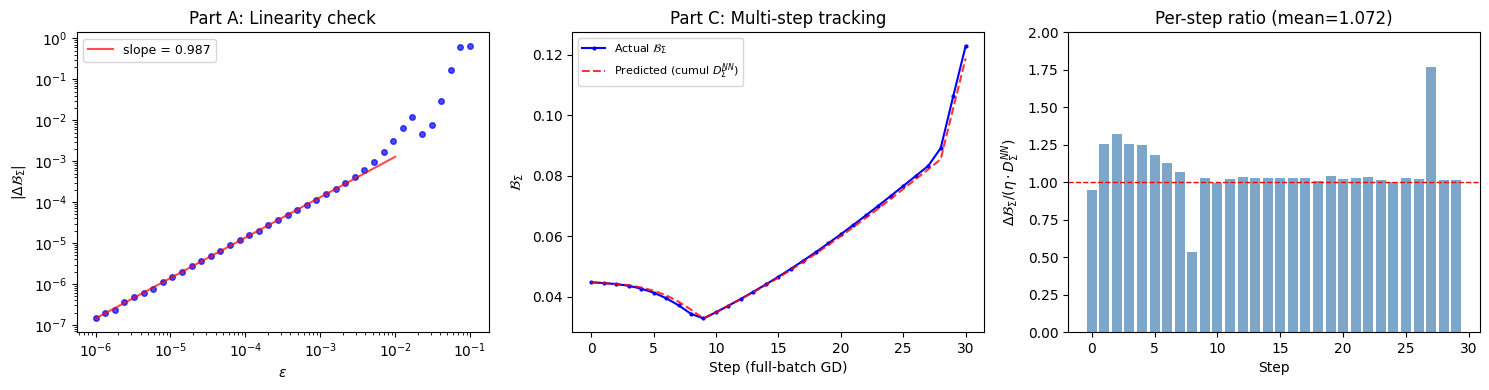

Figure saved.


In [10]:
# ── Experiment 4: Visualization ──

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Perturbation sweep (log-log)
ax = axes[0]
abs_delta_plot = np.abs(delta_bsig)
pos_mask = abs_delta_plot > 1e-12
ax.loglog(epsilons[pos_mask], abs_delta_plot[pos_mask], 'bo', markersize=4, alpha=0.7)
# Fit line
eps_fit = np.logspace(-6, -2, 100)
ax.loglog(eps_fit, 10**intercept_A * eps_fit**slope_A, 'r-', alpha=0.7,
          label=f'slope = {slope_A:.3f}')
ax.set_xlabel('$\\varepsilon$')
ax.set_ylabel('$|\\Delta\\mathcal{B}_\\Sigma|$')
ax.set_title('Part A: Linearity check')
ax.legend(fontsize=9)

# Plot 2: B_Σ trajectory — actual vs predicted
ax = axes[1]
steps_C = range(len(bsig_actual_C))
ax.plot(steps_C, bsig_actual_C, 'b.-', markersize=4, label='Actual $\\mathcal{B}_\\Sigma$')
ax.plot(range(len(bsig_pred_C)), bsig_pred_C, 'r--', alpha=0.8, label='Predicted (cumul $D_\\Sigma^{NN}$)')
ax.set_xlabel('Step (full-batch GD)')
ax.set_ylabel('$\\mathcal{B}_\\Sigma$')
ax.set_title('Part C: Multi-step tracking')
ax.legend(fontsize=8)

# Plot 3: Per-step ratio distribution
ax = axes[2]
valid_idx = [i for i, r in enumerate(ratios_C) if not np.isnan(r) and 0.5 < abs(r) < 2.0]
valid_vals = [ratios_C[i] for i in valid_idx]
ax.bar(valid_idx, valid_vals, color='steelblue', alpha=0.7)
ax.axhline(y=1.0, color='r', linestyle='--', linewidth=1)
ax.set_xlabel('Step')
ax.set_ylabel('$\\Delta\\mathcal{B}_\\Sigma / (\\eta \\cdot D_\\Sigma^{NN})$')
ax.set_title(f'Per-step ratio (mean={mean_ratio_C:.3f})')
ax.set_ylim(0, 2.0)

plt.tight_layout()
plt.savefig('figures/nn_exp4_effective_dsigma.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved.')